✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🚀 Using EfficientNet-B4 Pretrained Backbone

🚀 Training EfficientNet-B4...
💾 New Best Model: F1=0.5955 at Epoch 1
[Epoch 01] LR=1.00e-05, Train Acc=0.4280, Test Acc=0.6165, Test F1=0.5955, Train Loss=1.3418, Test Loss=1.2950
💾 New Best Model: F1=0.6672 at Epoch 2
[Epoch 02] LR=1.00e-05, Train Acc=0.6517, Test Acc=0.7158, Test F1=0.6672, Train Loss=1.2153, Test Loss=1.1086
💾 New Best Model: F1=0.7253 at Epoch 3
[Epoch 03] LR=1.00e-05, Train Acc=0.7352, Test Acc=0.7655, Test F1=0.7253, Train Loss=0.9837, Test Loss=0.8703
💾 New Best Model: F1=0.7910 at Epoch 4
[Epoch 04] LR=1.00e-05, Train Acc=0.7708, Test Acc=0.8037, Test F1=0.7910, Train Loss=0.8147, Test Loss=0.7555
💾 New Best Model: F1=0.8045 at Epoch 5
[Epoch 05] LR=1.00e-05, Train Acc=0.8135, Test Acc=0.8151, Test F1=0.8045, Train Loss=0.7325, Test Loss=0.7031
💾 New Best Model: F1=0.8062 at Epoch 6
[Epoch 06] LR=1.00e-05, Train Acc=0.8343, Test Acc=0.8182, Test F1=0.8062, T

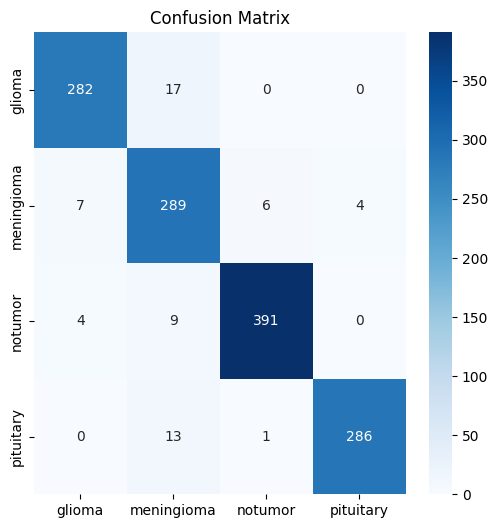

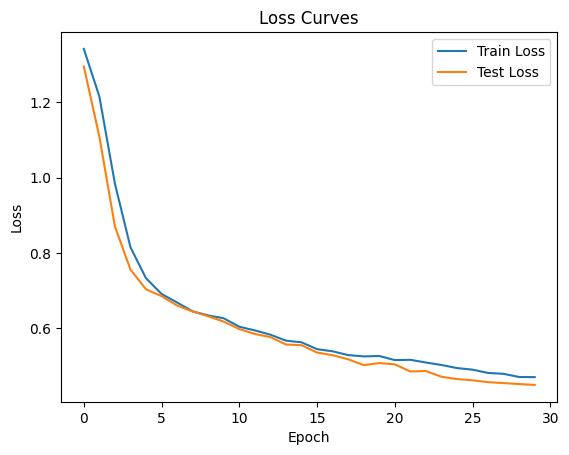

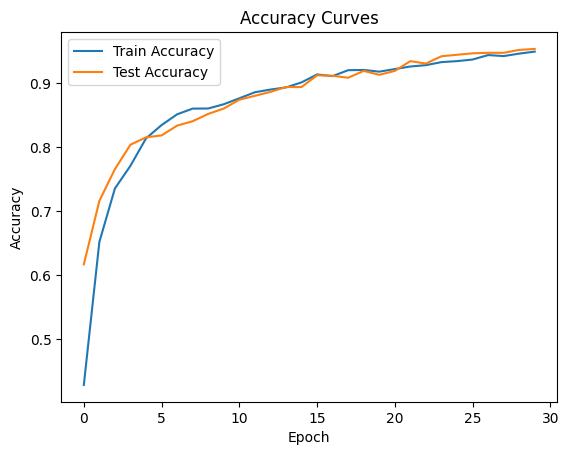

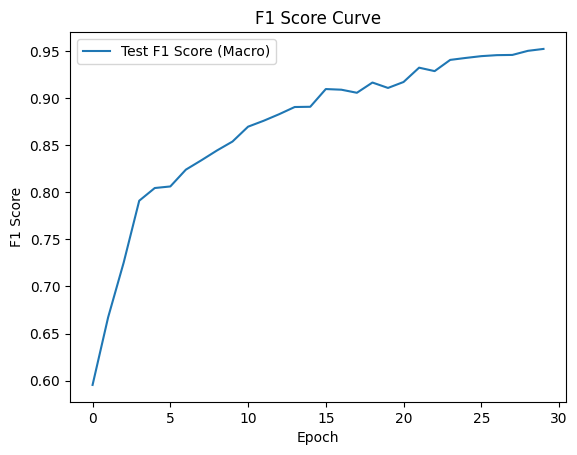

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time, warnings
warnings.filterwarnings("ignore")
import logging

# =====================
# SETTINGS
# =====================
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO, format='%(message)s')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 30
IMG_SIZE = 224
FINE_TUNE_LR = 1e-5

TRAIN_DIR = r"D:\garbage paper\garbage paper\archive\Training"
TEST_DIR  = r"D:\garbage paper\garbage paper\archive\Testing"

# =====================
# DATA TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transform)

# Verify class-to-index mapping
print(train_dataset.class_to_idx)

num_classes = len(train_dataset.classes)
logger.info(f"✅ Classes: {train_dataset.classes}")

# =====================
# BALANCED SAMPLER (for imbalance)
# =====================
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weight = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# =====================
# MODEL: EfficientNet-B4 Transfer Learning
# =====================
logger.info("🚀 Using EfficientNet-B4 Pretrained Backbone")
model = models.efficientnet_b4(weights="IMAGENET1K_V1")
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=FINE_TUNE_LR)
model = model.to(DEVICE)

# =====================
# LOSS / OPTIMIZER / SCHEDULER
# =====================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.2, patience=3
)

# Early Stopping (on F1)
best_f1 = 0
patience = 5
patience_counter = 0
best_epoch = 0

# Lists for storing metrics
train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []
f1_list = []

# =====================
# TRAINING LOOP
# =====================
logger.info("\n🚀 Training EfficientNet-B4...")
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # ---- EVAL ----
    model.eval()
    y_true, y_pred = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_acc = correct / total
    test_loss /= len(test_loader)

    # ---- METRICS ----
    test_f1 = f1_score(y_true, y_pred, average="macro")
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    f1_list.append(test_f1)

    scheduler.step(test_f1)

    # Early stopping
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        logger.info(f"💾 New Best Model: F1={best_f1:.4f} at Epoch {best_epoch}")
    else:
        patience_counter += 1
        logger.info(f"⚠️ No Improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            logger.info("⏹ Early stopping.")
            break

    lr = optimizer.param_groups[0]['lr']
    logger.info(f"[Epoch {epoch+1:02d}] "
                f"LR={lr:.2e}, "
                f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}, "
                f"Test F1={test_f1:.4f}, Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

logger.info(f"\n⏱ Training finished in {(time.time()-start_time)/60:.1f} min. Best F1={best_f1:.4f} at epoch {best_epoch}")

# =====================
# LOAD BEST MODEL
# =====================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
logger.info("🔄 Loaded best saved model for final evaluation.")

# =====================
# FINAL EVALUATION
# =====================
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = accuracy_score(y_true, y_pred)
final_prec = precision_score(y_true, y_pred, average="macro")
final_rec = recall_score(y_true, y_pred, average="macro")
final_f1 = f1_score(y_true, y_pred, average="macro")

logger.info("\n📊 FINAL PERFORMANCE SUMMARY")
logger.info("===================================")
logger.info(f"✅ Accuracy         : {final_acc*100:.2f}%")
logger.info(f"🎯 Precision (Macro): {final_prec:.4f}")
logger.info(f"📌 Recall    (Macro): {final_rec:.4f}")
logger.info(f"📈 F1-Score  (Macro): {final_f1:.4f}")

# =====================
# CONFUSION MATRIX
# =====================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# =====================
# TRAINING CURVES
# =====================
plt.figure()
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(f1_list, label="Test F1 Score (Macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Curve")
plt.legend()
plt.show()